# Optimizations (Draft)

## OR-tools

https://developers.google.com/optimization/introduction/python

In [ ]:
#!pip install ortools

Maximize $3x+y$

Subjected to:

$0 \le x \le 1$

$0 \le y \le 2$

$x+y \le 2$

In [ ]:
# Step 1: Import the required libraries.
from __future__ import print_function
from ortools.linear_solver import pywraplp

# Step 2: Declare the solver.
# Create the linear solver with the GLOP backend.
solver = pywraplp.Solver.CreateSolver('GLOP')

# Step 3: Create the variables.
x = solver.NumVar(0, 1, 'x')
y = solver.NumVar(0, 2, 'y')

print('Number f variables = ', solver.NumVariables())

# Define the constraints.
# The first two constraints are already set. The following code defines the remaining constraint
# Create a linear constraint, 0 <= x + y <= 2.
ct = solver.Constraint(0, 2, 'ct')
ct.SetCoefficient(x, 1)
ct.SetCoefficient(y, 1)

print('Number of constraints =', solver.NumConstraints())

# Step 4: Define the objective function.
objective = solver.Objective()
objective.SetCoefficient(x, 3)
objective.SetCoefficient(y, 1)
objective.SetMaximization()

# Step 5: Invoke the solver and display the results.
solver.Solve()
print('Objective value =', objective.Value())
print('x =', x.solution_value())
print('y =', y.solution_value())




Number f variables =  2
Number of constraints = 1
Objective value = 4.0
x = 1.0
y = 1.0


## My Simplex Method implementation

In [ ]:
import numpy as np

class SimplexSolver():
    """A solver of standard form with simplex method."""
    def __init__(self):
        self.m = int(input("Number of constraints: "))
        self.n = self.m + int(input("Number of variables: "))
        self.B = [i for i in range(self.n - self.m, self.n)]
        self.N = [i for i in range(self.n - self.m)]
        self.c = np.array([[float(i)] for i in input("Coefficient of objective: ").split()] + [[0]]*self.m)
        print("Coefficient of constraint:")
        container = []
        for _ in range(self.m):
            container.append([float(i) for i in input().split()])
        
        self.A = np.hstack((np.array([row[:-1] for row in container]), np.identity(self.m)))
        self.b = np.array([[row[-1]] for row in container])
        
        self.p, self.Q, self.z, self.r = [], [], [], []
        self._update_tablaeu()
        self._solve()

    def objective_value(self):
        return self.z[0, 0]
    
    def optimal_solution(self):
        if self.z != float('inf'):
            result = [0]*(self.n - self.m)
            for j in range(self.m):
                if self.B[j] in range(self.n - self.m):
                    result[self.B[j]] = self.p[j, 0]
            return result
        else: return None

    def _update_tablaeu(self):
        self.p = np.linalg.inv(self._part(self.A, self.B)) @ self.b
        self.Q = - np.linalg.inv(self._part(self.A, self.B)) @ self._part(self.A, self.N)
        self.z = (self._part(self.c, self.B, False)).T @ np.linalg.inv(self._part(self.A, self.B)) @ self.b
        self.r = self._part(self.c, self.N, False) - ((self._part(self.c, self.B, False)).T @ np.linalg.inv(self._part(self.A, self.B)) @ self._part(self.A, self.N)).T
    
    def _part(self, A, B, column=True):
            return np.hstack([A[:, i:i+1] for i in B]) if column else np.vstack([A[i:i+1, :] for i in B])

    def _entering_position(self):
        """Return the INDEX in N of the basic-entering variable, which has positive coefficient."""
        for j in range(self.n - self.m):
            if self.r[j, 0] > 0:
                return j
        return None

    def _leaving_position(self, beta):
        """Return the INDEX in B of the basic-leaving variable, or None if there is no row with a negative coefficient of entering variable (unbounded)"""
        lower_bound = sorted([(- self.p[i, 0]/self.Q[i, beta], i) for i in range(self.m) if self.Q[i, beta] < 0])
        return lower_bound[0][1]

    def _solve(self): # must handle the no BFS case
        beta = self._entering_position() 
        while beta != None:
            alpha = self._leaving_position(beta)
            self._status()                      # REMOVE this line in execution
            if alpha == None: 
                self.z = float('nf')
                return
            else:
                self.B[alpha], self.N[beta] = self.N[beta], self.B[alpha]
                self._update_tablaeu()
                beta = self._entering_position()


    def _status(self):
        print(self.B, self.N)
        print(self.p)
        print(self.Q)
        print(self.z)
        print(self.r)

#solver = SimplexSolver()
#print(solver.objective_value())
#print(solver.optimal_solution())


## Mixed integer programming

Maximize $x + 10y$ 

subject to:

$x + 7y \le 17.5$

$x \le 3.5$

$x \ge 0$

$y \ge 0$

$x, y$ are integers

In [ ]:
# Import the linear solver wrapper
from ortools.linear_solver import pywraplp

# Declare the MIP solver
solver = pywraplp.Solver.CreateSolver('SCIP')

INF = solver.infinity()

x = solver.IntVar(0.0, INF, 'x')
y = solver.IntVar(0.0, INF, 'y')

# Define the constraints
solver.Add(x + 7*y <= 17.5)
solver.Add(x <= 3.5)

# Define the objective
solver.Maximize(x + 10*y)

# Call the MIP solver
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    print('x =', x.solution_value())
    print('y =', y.solution_value())
else:
    print('The problem does not have an optimal solution.')

BCA problem

In [ ]:
# BCA problem


from ortools.linear_solver import pywraplp
import numpy as np

solver = pywraplp.Solver.CreateSolver('SCIP')
INF = solver.infinity()

T, N = 3, 13
credits = np.array([3,3,4,3,4,3,3,3,4,3,3,4,4])
preference = np.array([[1,0,1,1,1,0,0,0,1,0,1,0,0],[1,1,0,1,0,1,1,1,1,0,0,0,0],[0,1,1,1,0,0,0,1,0,1,0,1,1]])
conflict = np.array([[0,2],[0,4],[0,8],[1,4],[1,10],[3,7],[3,9],[5,11],[5,12],[6,8],[6,12]])

X = np.array([[None]*N for _ in range(T)])
Y = solver.IntVar(-INF, INF, 'Y')
for i in range(T):
    for j in range(N):
        X[i, j] = solver.IntVar(0.0, float(preference[i, j]), 'X[{}, {}]'.format(i, j))

for i in range(T):
    solver.Add(Y >= sum(X[i, j]*credits[j] for j in range(N)))

for j in range(N):
    solver.Add(sum(X[:, j]) <= 1)

for j in range(N):
    solver.Add(sum(X[:, j]) >= 1)

for i in range(T):
    for j1, j2 in conflict:
        solver.Add(X[i, j1] + X[i, j2] <= 1)

solver.Minimize(Y)

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    print([[j for j in range(N) if X[i, j].solution_value() == 1] for i in range(T)])
else:
    print('The problem does not have an optimal solution.')


## Constraint Optimization

Three variables,$x$, $y$, and $z$, each of which can take on the values: $0$, $1$, or $2$.

One constraint: $x ≠ y$

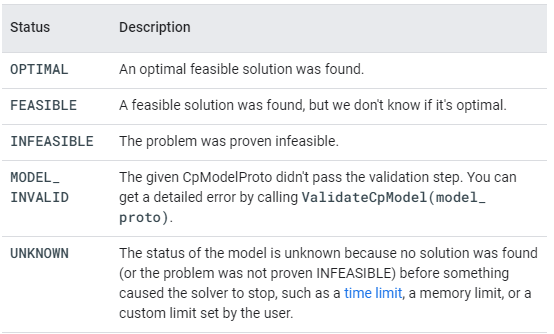

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from ortools.sat.python import cp_model


class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0

    def on_solution_callback(self):
        self.__solution_count += 1
        for v in self.__variables:
            print('%s=%i' % (v, self.Value(v)), end=' ')
        print()

    def solution_count(self):
        return self.__solution_count


def SearchForAllSolutionsSampleSat():
    """Showcases calling the solver to search for all solutions."""
    # Creates the model.
    model = cp_model.CpModel()

    # Creates the variables.
    num_vals = 3
    x = model.NewIntVar(0, num_vals - 1, 'x')
    y = model.NewIntVar(0, num_vals - 1, 'y')
    z = model.NewIntVar(0, num_vals - 1, 'z')

    # Create the constraints.
    model.Add(x != y)

    # Create a solver and solve.
    solver = cp_model.CpSolver()
    solution_printer = VarArraySolutionPrinter([x, y, z])
    status = solver.SearchForAllSolutions(model, solution_printer)

    print('Status = %s' % solver.StatusName(status))
    print('Number of solutions found: %i' % solution_printer.solution_count())


SearchForAllSolutionsSampleSat()

## Gradient descent method

if:
* $f: \mathbb{R}^n \rightarrow \mathbb{R}$ is convex
* unconstrained

Denote: $f^* = min_x f(x)$ and $x^* = argMin_x f(x)$

Algorithm:
>* compute minimizing sequence $x^{(0)}, x^{(1)},... x^{(k)}$ s.t $f(x^{(k)}) \rightarrow f^*$ as $k \rightarrow \infty$
>* stop at $x^{(k)}$ when $f(x^{(k)}) - f^* \le \epsilon$

if $x*$ is a local minimizer for $f$:
>* Necessary condition: $\nabla f(x^*) = 0$
>* Sufficient condition: $\nabla^2 f(x^*)$ is positive definite.

<details>
    <summary> Recall positive definite </summary>
    
$ A = \begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{21} & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix}
$
    
is positive definite if $|A^i| > 0$, $\forall i = 1, \cdots n$
    
</details>

### Descent methods

Algorithm:
> determine starting point $x^{(0)} \in \mathbb{R^n}$
>
> while not (stop condition reach):
>> determine a search direction $p_k \in \mathbb{R^n}$
>>
>> determine a step size $\alpha_k > 0$ s.t $f(x^{(k)} + \alpha_k p_k) < f(x^{(k)})$
>>
>> $x^{(k + 1)} \leftarrow x^{(k)} + \alpha_kp_k$
>>
>> $k \leftarrow k + 1$


#### Gradient descent method

> Gradient descent schema: $x^{(k)} \leftarrow x^{(k - 1)} - \alpha_k \nabla f(x^{(k-1)})$

> $\alpha_k$ might be specified in such a way that $f(x^{(k)})$ is minimized: $\displaystyle \frac{\partial{f}}{\partial{\alpha_k}} = 0$

Algorithm:
> init $x^{(0)}$
>
> $k = 1$
>
> while not (stop condition reach):
>> specify constant $\alpha_k$
>>
>> $x^{(k)} = x^{(k - 1)} - \alpha_k \nabla f(x^{(k-1)})$
>>
>> $k = k + 1$


> Stop condition may be:
>* $\parallel \nabla f(x^{(k)}) \parallel \le \epsilon$
>* $\parallel x^{(k + 1)} - x^{(k)} \parallel \le \epsilon$
>* $k > K$ (maximum number of iterations)


## Heuristics

Optimization problems:

* continuous
>* Linear program (simplex method)
>* Non-linear program (gradient method, newton method, subgradient, Lagrangian relation)


* integer/discrete
>* Exact methods (Branch and cut, Bracnh and bound, Constraint programming)
>* High quality solutions found in a reasonable computation time (Heuristics)

Problems to solve with the Greedy algorithm:

* TSP problem
* Multi-knapsack problem

## Constraint linearization

"How ot model $(x = 1) \implies (z \ge y)$" where $x$ is a binary variable:
$M(x - 1) + y \le z$

### Travelling salesman problem

$Y(i)$: accumulated distance from point $1$ to point $i$

$X(i, j)$: binary variable, $=1$ if $Y(j) = Y(i) + d(i, j)$

$\implies Y(j) + M(1-X(i, j)) \ge Y(i) + d(i, j)$ and $Y(j) + M(X(i, j) - 1) \le Y(i) + d(i, j)$

### Resource constrained shortest path problem

### MultiCast Routing Problem

# Numpy (Draft)

```
>>> np.arange(6)
[0 1 2 3 4 5]
```

```
>>> np.arrange(6).reshape(2, 3)
[[0 1 2]
 [3 4 5]]
```

```




In [ ]:
import numpy as np

a = np.arange(6).reshape(2, 3)

print(a.ndim)

#### 7. Planar graph

if it can be drawn in the plane
without any edges crossing.

<details>
<summary> Illustration </summary>

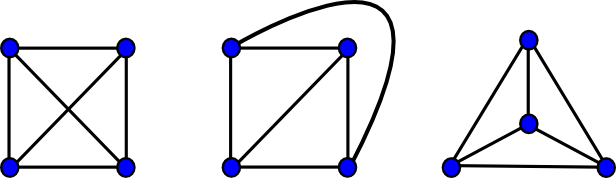
</details>

Euler showed that all **planar representations** of a graph split the plane into the same number of regions, including an unbounded region.
> *In a planar representation of a graph: $r = e - v + 2$*.

> *$G$ is a connected planar simple graph, then*:
>* $e \le 3v - 6$*
>* $G$ must have a vertex of degree not exceeding $5$.
>* $e \le 2v - 4$ if there is no circuits of length $3$.

#### 8. Euler graph and Hamilton graph

Terminology:

>* ***Euler path***: a path that traverses through every edge exactly once.
>* ***Euler cycle***: a Euler path that begins and ends at the same vertex.
>* ***Half Euler graph***: Graph consisting of Euler path.
>* ***Euler graph***: Graph consisting of Euler cycle.

<details>
<summary> Illustration </summary>

insert image here
</details>

Theorems:

>* If a graph has any vertices of odd degree, then it can not have any
Euler cycle.
>* If a graph is connected and every vertex has an even degree, then it
has at least one Euler cycle.
>* If a graph has more than two vertices of odd degree, then it cannot
have an Euler path.
>* If a graph is connected and has exactly two vertices of odd degree,
then is has at least one Euler path. Any such path must start at one of
the odd degree vertices and must end at the other odd degree vertex.

## Tree and Spanning Tree

Theorem: 
> Given an undirected graph $G$, the following conditions are equivalent:
>>* $G$ is a tree
>>* For every two vertices $u, v$, there exists exactly one simple path from $u$ to $v$.
>>* $G$ is connected and $|E| = |V | − 1$.
>
> Cayley theorem: A complete graph $K_n$ has $n^{n-2}$ spanning trees.
>> <details>
>> <summary> Illustration </summary>
>>
>>
>> </details>

### What is AI

||Mimic humans|Reach an ideal
|-|---|---|
Reasoning|Think like humans|Think rationally|
Behaviours|Act like humans|Acting rationally|

Muriel VISANI:  murielv@soict.hust.edu.vn

**Act like humans**, needs:
>* Reply questions
>>* ***Natural Language Processing***, to “understand” language
>>* ***Knowledge Representation***, to store the information provided with
>>* ***Automated Reasoning***, using its knowledge to answer
>>* ***Machine Learning*** *, to “generalize” its knowledge to new/unexpected questions
>* Respond to a video signal
>>* ***Computer Vision*** *, to perceive the information in the video
>* Manipulate objects
>>* ***Robotics*** (on top of computer vision, to actually “see” the objects)

**Think like humans**, needs:
>* Understanding how the brain works, either by:
>>* Introspection
>>* Psychological experiments
>>* Brain imaging (most recent)
>>
>> They are parts of Cognitive science and Neuroscience

**Thinking rationally**, needs:
>* The “Laws of Thought” approach
>>* Maths + Philosophy -> roots of the field of **Logics**
>>* Normative / prescriptive rather than descriptive
>* Difficulties:
>>* Not all intelligent behavior is mediated by logical deliberation
>>* Not everything can be expressed by rules (uncertainty)

**Acting rationally**:
>* The right thing: what is needed to reach the objective, given the
available information
>* Doesn't necessarily involve thinking, (e.g., humans blinking)
>* The definition of a rational behavior depends on the objective(s)
>* Irrational ≠ insane, Rational ≠ successful
>* Relies on ***rational agents***:
>> 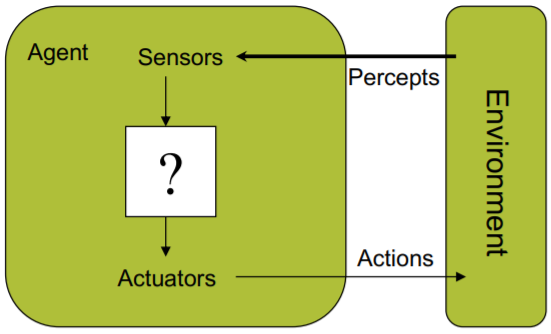
>>
>> An ***agent*** is an entity that **perceives** and *acts*.
>>
>> An ***agent function*** maps from percept histories to actions: $P \rightarrow A$

### Foundations of AI

>* Philosophy
>>* rationalism
>>* reasoning methods
>>* language
>>* dualism
>>* empiricism
>* Mathematics
>>* logic
>>* formal representation
>>* (in)completeness / (in)tractability
>>* probability & statistics (induction)
>>* proofs
>* Economics: utility (preferred outcomes), decision theory, game theory
>* Operations research: the objective is achieved only after a sequence of actions (e.g. Markov decision processes)
>* Control theory design systems that maximize an objective function over time
>* Linguistics: knowledge representation



### Different kinds of approaches can be used for AI
>* Knowledge-based approaches
>* Statistical approaches
>* Agent-based approaches

### Short history and challenges AI

> 2000—: Where are we now? -> Some call it the “deep learning era”
>

Some current challenges:
>* In Natural Language Processing
>> Setting the context, extracting semantic meanings
>* In Knowledge Representation
>> Transfer the knowledge from one domain to another
>* In Automated Reasoning
>> Towards eXplainable Artificial Intelligence (XAI)
>* In Machine Learning
>> Conceiving algorithms capable of learning their own parameters
>* In Computer Vision
>> Transfer learning / domain adaptation
>* In Robotics
>> Facilitating human-robot collaboration (reliability, user acceptance…)

## Chapter 2: Intelligent agents

### Purpose of intelligent agents

***Agent***:

![image.png](attachment:image.png)

***Agent function***: maps from percept histories to actions:
$$f: P* \rightarrow A $$

Example:
* robotic agent (e.g., Aishimo)
>* Sensors: camera, infrared range finders
>* Actuators: various motors
* software agent
>* Sensors: keypad, file uploader, network packet receiver…
>* Actuators: screen, file writer, network packet sender…

The agent’s ***percept sequence*** is the complete history of percepts received by the agent. In general, an agent acts based on its percept sequence, but NOT on anything it did NOT perceive.

One (basic) way to implement the agent function is
to map any given percept sequence to an action:


```
Function TABLE-DRIVEN-AGENT(input_percept)
    static: current_percept_sequence: initially empty
            table: a table of actions, indexed by all possible percept sequences, initially fully specified
    Append input_percept to the end of current_percept_sequence
    action = LOOKUP(current_percept_sequence, table)
    Return action
    
# Drawback: huge table!
```

***Rational agent***: does the right thing - the one that will cause the agent to be most successful. Depends on:
>* ***Performance measure***: embodies the criterion for success of an agent’s behavior.
>* The agent’s prior knowledge of the environment
>* The actions that the agent can perform
>* The agent’s percept sequence to date
>
> Rationality $\ne$ perfection
>
> For each possible percept sequence, a rational
agent should select an action that:
>>* is expected to maximize its performance measure…
>>* given the evidence provided by the percept sequence…
>>* and given the built-in knowledge the agent has

### PEAS

4 factors should be considered when designing an automated agent:
>* ***Performance measure***
>* ***Environment***
>* ***Actuators***
>* ***Sensors***

### Environment types

>* ***Known*** (vs. unknown): relative to the knowledge of the agent regarding its environment
>* ***Fully observable*** (vs. partially observable): sensors access to the complete state of the environment at each point in time.
>* ***Deterministic*** (vs. stochastic): The next state of the environment is completely determined by the current state and the action executed by the agent.
>* ***Single agent*** (vs. multiagent): An agent operating by itself in an environment. For multiagents: competitive vs. cooperative
>* ***Static*** (vs. dynamic): The environment is unchanged while an agent is deliberating.
>* ***Discrete*** (vs. continuous): A limited number of distinct, clearly defined percepts and actions.
>* ***Episodic*** (vs. sequential): The agent's experience is divided into atomic "episodes" (percept + action). The next episode does NOT depend on the actions taken in previous episodes.

### Agent types

An ***autonomous*** agent can learn from its experience, to compensate for partial or incorrect prior knowledge of its environment.

Four basic agent types:
>* ***Simple reflex agents***
>> select actions on the basis of the **current percept**, **ignoring** the rest of the **percept history**.
>> ![image.png](attachment:image.png)
>* ***Model-based reflex agents***
>> maintain internal states that depends on the percept history and thereby reflects at least some of the unobserved aspects.
>> ![image.png](attachment:image.png)
of the current state.
>* ***Goal-based agents***
>> take actions in the pursuit of a goal(or multiple goals).
>> x-special/nautilus-clipboard
copy
file:///home/ubuntu/Pictures/Screenshot%20from%202020-11-25%2011-06-36.png
>* ***Utility-based agents***
>> take actions making them the happiest in the long run.
>> x-special/nautilus-clipboard
copy
file:///home/ubuntu/Pictures/Screenshot%20from%202020-11-25%2011-04-53.png

***Leanring agents***:
> x-special/nautilus-clipboard
copy
file:///home/ubuntu/Pictures/Screenshot%20from%202020-11-25%2011-07-57.png
> Example: For a taxi driver agent, please identify what could be:
>>* The performance standard: safety, where to go, how fast
>>* The performance element: knowledge and procedures to selecting actions
>>* The critic: eg after making a U-turn where forbidden, it is fined by police
>>* The learning element: from experience, formulate a rule that you cannot make a U-turn where forbidden.
>>* The problem generator: 

## Chapter 3: Problem solving

Solving problems by searching

### ***Problem-solving agents***

are a special kind of goal agents.

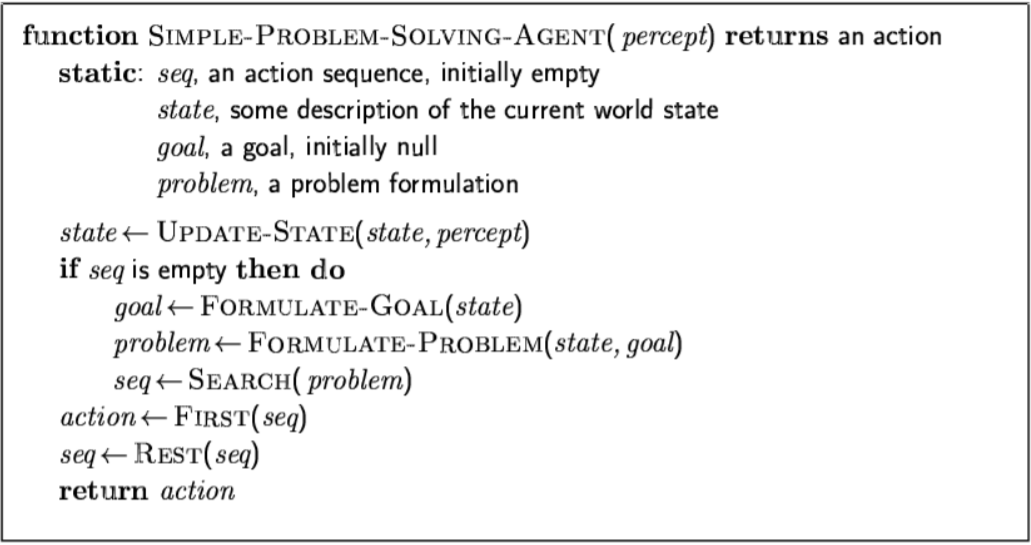

### Example: Route Planning

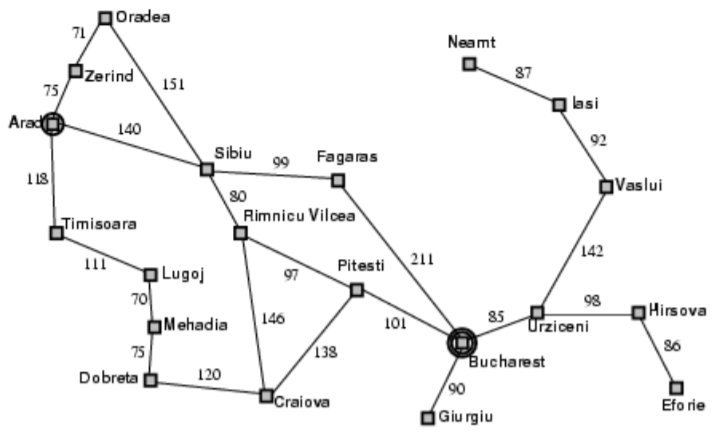


* ***Goal***: Get from Arad to Bucharest
* ***Performance***: as little km as possible
* ***Environment***: the map, with cities, roads, and km between cities
* ***Actions***: Travel a road between adjacent cities
* ***Formulation***: of actions: notion of abstraction

***Search Problem Formulation***:

1. ***Initial state***: Arad
2. ***Actions/transition model*** (or ***successor function***): S(x) = set of action-state pairs, S(Arad) = {$<$ Arad, Arad $\rightarrow$ Sibiu, Sibiu $>$,... }
3. ***Goal test***: Bucharest
4. ***Path cost***:  sum of distances or number of actions executed, where $c(s,a,s’)$ is the ***step cost***

> $1$ and $2$ are ***state space*** of the problem.

A ***solution*** is a sequence of actions leading from
the initial state to a goal state

### Basic search algorithms

#### Convert search graph into search tree

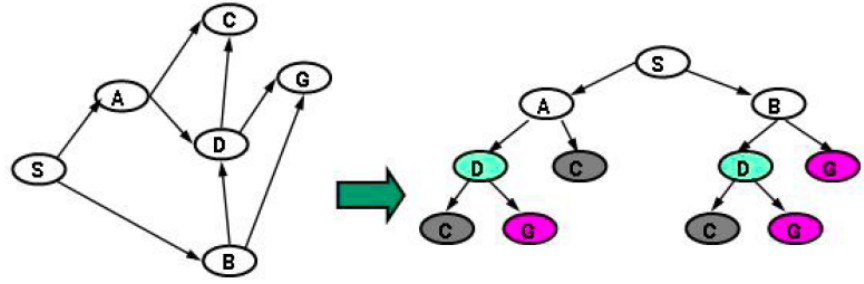

#### ***states*** vs. ***nodes***

1. ***states***:  a representation of a physical configuration.
2. ***node***: is a data structure includes ***state***, ***parent node***, ***action***, ***path cost $g(x)$***, ***depth***.

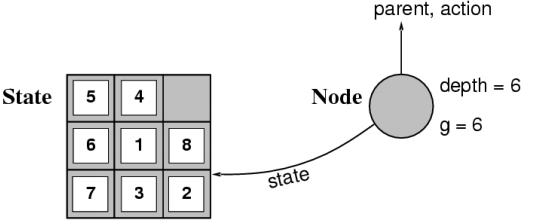

> ```Expand```: function to create new nodes (with their attributes)
>
> ```SuccessorFn```: create the corresponding
states


#### General tree search

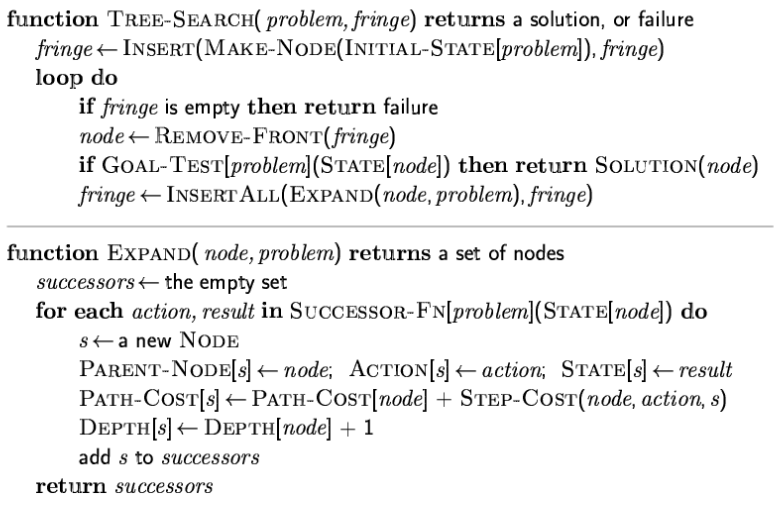

#### Search strategies

is defined by picking the **order of node expansion**.


Time and space complexity are measured in terms of:
>* $b$: maximum branching factor of the search tree.
>* $d$: depth of the least-cost solution (shallowest node achieving goal).
>* $m$: maximum depth of the state space (may be $∞$)

**Uninformed search strategies**:

1. Breadth-first search
> Expand shallowest unexpanded node
>
> fringe = queue (FIFO)
>

<details> 
    <summary> Illustration </summary>

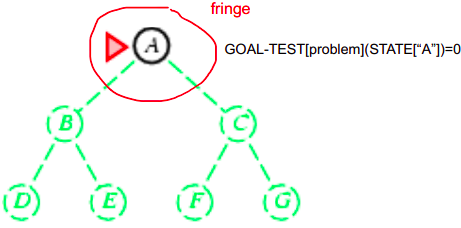
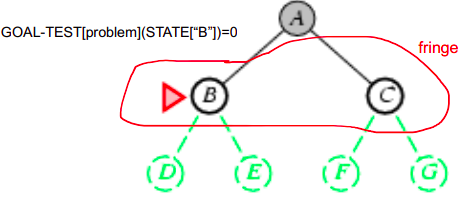
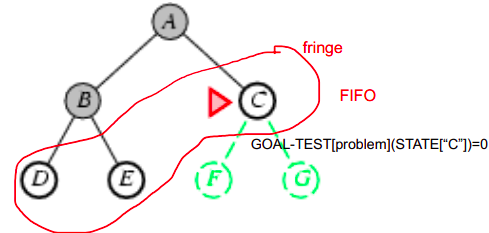
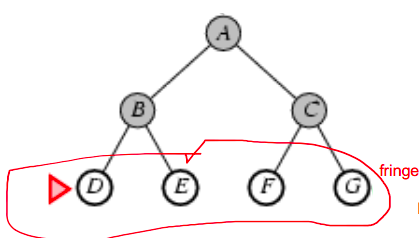
</details>
    
2. Uniform-cost search
> Expand cheapest unexpanded node
>
> fringe = priority queue ordered by path cost


<details>
    <summary> Illustration </summary>
    
Example: go from Sibiu to Bucharest with no U-turns, and uniform-
cost search

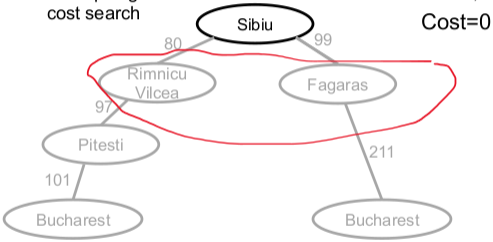

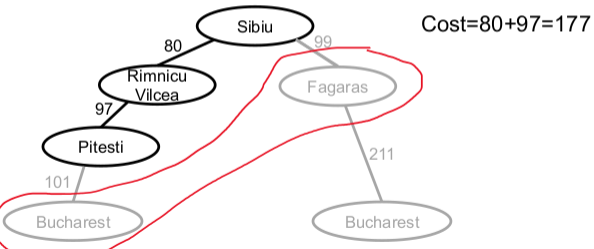

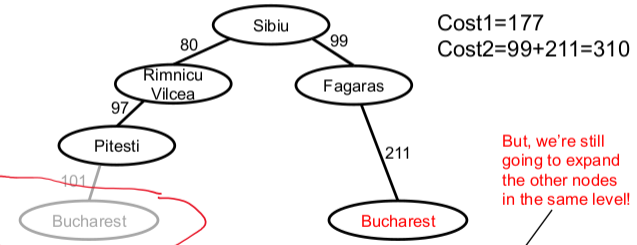

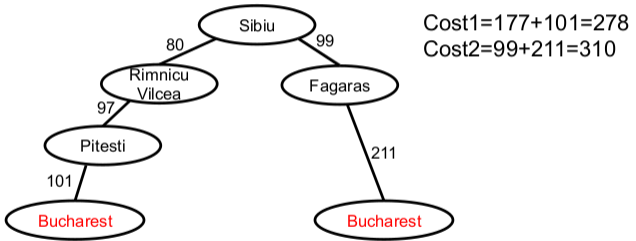

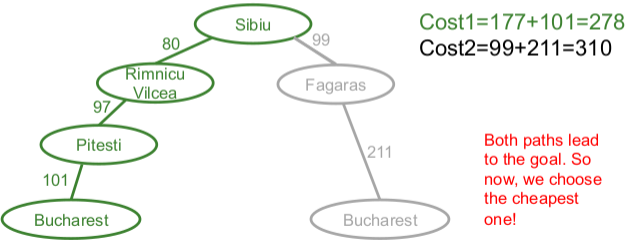
</details>

3. Depth-first search
        
> Expand deepest unexpanded node
>
> fringe = stack (LIFO)
>
> Complete? No: fails in infinite-depth spaces


4. Depth-limited search
        
> depth-first search with depth limit

<details>
<summary> Illustration </summary>

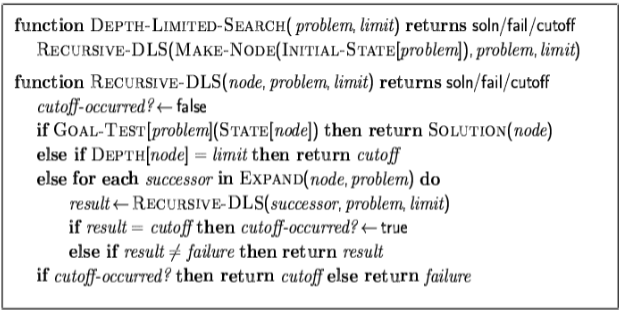

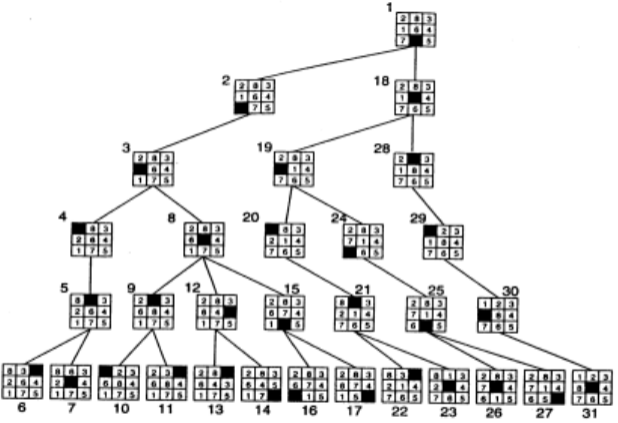
</details>

5. Iterative deepening search

<details>
<summary> Illustration </summary>

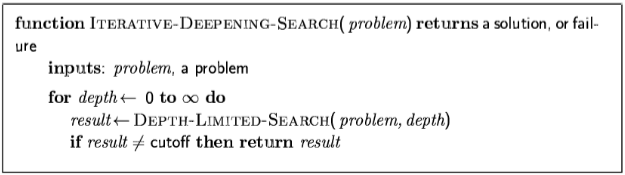

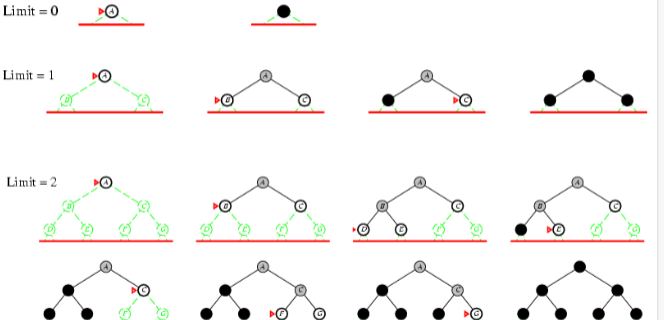

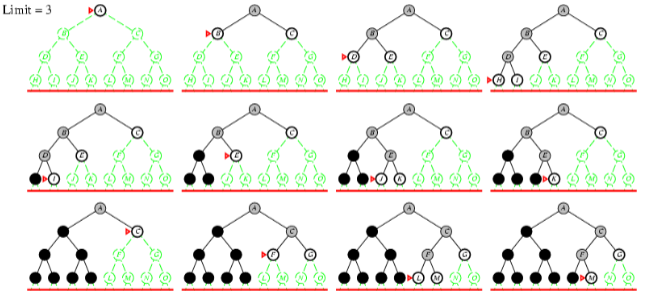
</details>

#### Summary of algorithms

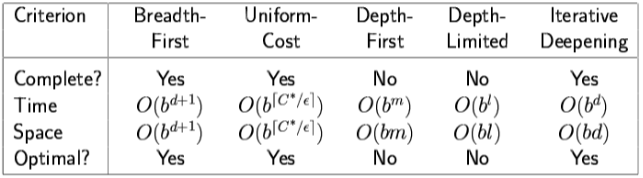

### Graph Search

Goal: Get from Arad to Bucharest with as little km as possible

<details>
    <summary> Map </summary>
    
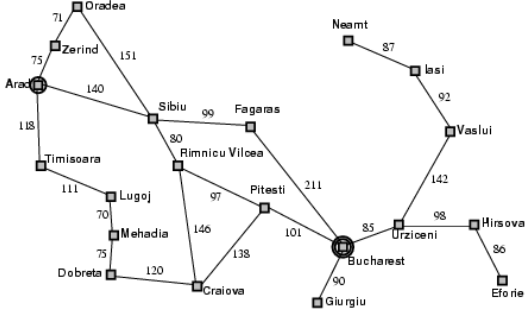
</details>

If we use Tree search, repeated states may turn
a linear problem into an exponential one!

### Adversarial search

**Multi-agent** environment:
* Any given agent needs to consider the actions of other
agents (past, current and / or future) to select their next
action
* Introduce possible contingencies into the agent’s
problem-solving process

For adversarial search, the environment is **competitive**
(and not collaborative)
* Agents have conflicting goals

#### Games v.s. search problems

”Usual” search: no adversary
* Solution: (heuristic) method for reaching
goal
* Heuristics and CSP techniques can find
optimal solution
* Evaluation function: estimate of cost from
start to goal through given node
* Examples: path planning, scheduling
activities

Games: adversarial search
* "Unpredictable" opponent
* Solution is a strategy
>* strategy specifies the “best” move
(action) for every possible opponent reply
* Time limits force an approximate solution
* Evaluation function: evaluate “goodness” of game position

##### Deterministic games in practice

1994, checkers: Chinook defeated the 40-year-long
human world champion.

> a precomputed endgame database
defining perfect play for all positions involving 8 or
fewer pieces on the board

#### 2-player game problem formulation

Minimax:
>* A game with 2 players: MAX and MIN
>* MAX moves first, turn-taking, until the game is over
>* Winner gets award (+1), looser gets penalty (-1)
>* This problem can be defined as a **search problem** with:
>>* ***initial state***: initial position(s) (fixed in most board games)
>>* ***player***: player to move (a.k.a to take an action)
>>* ***successor function***: a list of legal (move, state) pairs
>>* ***goal test***: is the game over? terminal states
>>* ***utility function***: gives a numeric value for the terminal states
>>>* E.g. win (+1), loose (-1) and draw (0) in tic-tac-toe
>* ***Game tree*** = initial state + legal moves
>>* MAX uses the search tree to determine its next move
>>* Perfect for playing deterministic games

<details>
    <summary> Minimax image </summary>
    
file:///home/ubuntu/Pictures/Screenshot%20from%202020-12-05%2009-01-48.png![image.png](attachment:image.png)

file:///home/ubuntu/Pictures/Screenshot%20from%202020-12-05%2009-11-24.png![image.png](attachment:image.png)
    
file:///home/ubuntu/Pictures/Screenshot%20from%202020-12-05%2009-15-30.png![image.png](attachment:image.png)    
</details>

α-β pruning: Remove branches that will not influence the final decision
> ...

Cut-off and EVAL strategies

#### backtracking

# Others' solutions

## [Human readable duration format](https://www.codewars.com/kata/52742f58faf5485cae000b9a/python)

```
1 minute and 2 seconds
1 hour, 1 minute and 2 seconds
```

In [ ]:
times = [("year", 365 * 24 * 60 * 60), 
         ("day", 24 * 60 * 60),
         ("hour", 60 * 60),
         ("minute", 60),
         ("second", 1)]

def format_duration(seconds):

    if not seconds:
        return "now"

    chunks = []
    for name, secs in times:
        qty = seconds // secs
        if qty:
            if qty > 1:
                name += "s"
            chunks.append(str(qty) + " " + name)

        seconds = seconds % secs

    return ', '.join(chunks[:-1]) + ' and ' + chunks[-1] if len(chunks) > 1 else chunks[0]

In [ ]:
def format_duration(seconds):
    if seconds == 0: return "now"
    units = ( (31536000, "year"  ), 
              (   86400, "day"   ),
              (    3600, "hour"  ),
              (      60, "minute"),
              (       1, "second") )
    ts, t = [], seconds
    for unit in units:
        u, t = divmod(t, unit[0])
        ts += ["{} {}{}".format(u, unit[1], "s" if u>1 else "")] if u != 0 else []
    return ", ".join([str(d)for d in ts[:-1]]) + (" and " if len(ts)>1 else "") + ts[-1]

# Exercises

In [ ]:
def key_sort(A):
    return A[1]


def natural_join(A, B):
    A.sort(key=key_sort)
    B.sort()
    c = []
    i = j = 0
    while i < len(A) and j < len(B):
        if A[i][1] == B[j][0]:
            c.append((A[i][0], A[i][1], B[j][1]))
            i += 1
            j += 1
        elif A[i][1] < B[j][0]:
            i += 1
        else:
            j += 1
        if i == len(A) or (j == len(B)):
            break
    return c

def mysum(A, r_start, r_stop, c_start, c_stop):
    if r_start == r_stop or c_start == c_stop:
        return 0
    else:
        return A[r_start][c_start] + mysum(A, r_start + 1, r_stop, c_start + 1, c_stop) + mysum(A, r_start + 1, r_stop, c_start, c_start + 1) + mysum(A, r_start, r_start + 1, c_start + 1, c_stop)

A = [[1, 2, 3],
     [4, 5, 6]]
print(mysum(A, 0, 2, 0, 3))

In [ ]:
s = ['a', 'b', 'c']
[[x for (pos,x) in zip(range(len(s)), s) if (2**pos) & b] for b in range(2**len(s))]

In [ ]:
# Xet cac day con cua S lap thanh mot cap so cong. In ra max cua cac tong cua tung day con do.
# VD: [-2, 1, -3, 4, -1, 2, 1, -5, 4] -> 8   (day so cong co tong lon nhat la: 4, 4)


def max_sum_addition(S, i):
    # find the maximum sum among sums of sequences of addtion started at S[i]

    def addition_step(start, stop):
        # return the next expected gap
        next_step = start
        while next_step < stop:
            yield next_step
            next_step += start
        yield start - 1

    # find the gap
    for j in range(i + 1, len(S)):
        S[j] -= S[i]
    
    #print(S)
    
    list_of_sums = [S[i]]

    for j in range(i + 1, len(S)):      # j is the currently considered arithmetical ratio
        gen_step = addition_step(S[j], S[-1] + 1)coin
        temp_sum = S[i]
        expected_step = next(gen_step)
        for k in range(j, len(S)):
            #print(S[i], expected_step, S[k])
            if S[k] == expected_step:
                temp_sum += S[i] + S[k]
                expected_step = next(gen_step)
        list_of_sums.append(temp_sum)

    #print(".", list_of_sums)
        
    for j in range(i + 1, len(S)):
        S[j] += S[i]

    return max(list_of_sums)

S = [1,2,3,4]
S.sort()
#print(S)
max_sum = max_sum_addition(S, 0)
for i in range(1, len(S)):coin
    candidate = max_sum_addition(S, i)
    if candidate > max_sum:
        max_sum = candidate
print(max_sum)


In [ ]:
def max_subarray(a):
    n = len(a)
    b = [float('-inf'), *a, float('inf')]
    L = [1] * (n + 2)
    T = [None] * (n + 2)
    for i in range(n, -1, -1):
        j_max = n + 1
        for j in range(i + 1, n + 2):
            #print(i, j, n + 1)
            if b[i] < b[j] and L[j] > L[j_max]:
                j_max = j
        L[i] = L[j_max] + 1
        T[i] = j_max
    return b, L, T

b, L, T = max_subarray([5, 2, 3, 4, 9, 10, 5, 6, 7, 8])coin
print(b)
print(L)
print(T)

In [ ]:
def matrix_mul_2(sizes):
    n = len(sizes) - 1                      # number of matrixs
    M = [[-1]*n for _ in range(n)]          # -1 denotes the value is not computed
    
    def recur_mul(i, j, sizes, M):
        if M[i][j] == -1:
            if i == j:
                M[i][j] = 0
            else:
                M[i][j] = min([recur_mul(i, k, sizes, M) + recur_mul(k + 1, j, sizes, M) + sizes[i]*sizes[k + 1]*sizes[j + 1] for k in range(i, j)])
        return M[i][j]

    return recur_mul(0, n - 1, sizes, M)
coin
print(matrix_mul_2([10, 30, 5, 60]))

In [ ]:
def Generating(n):
    arr = ['0'] * n
    while True:
        i = n - 1
        print(''.join(arr))
        while arr[i] == '1':
            arr[i] = '0'
            i -= coin
            if i == -1:
                return
        arr[i] = '1'


def Backtracking(n):
    a = [None] * n
    
    def Try(k):
        for bit in range(2):
            a[k] = bit
            if k == n - 1: print(a)
            else: Try(k + 1)
    Try(0)

"""
boolean solve(Node n) {
    put node n on the stack;
    while the stack is not empty {
        if the node at the top of the stack is a leaf {
            if it is a goal node, return true
            else pop it off the stack
        }
        else {
            if the node at the top of the stack has untried children
                push the next untried child onto the stack
            else pop the node off the stack

    }
    return false
}

nonrecur_algo(n):
    create a stack, put node 0 in the stack
    while stack is not empty:
        if stack[-1] is leaf:
            print result
            pop that stack[-1]
        else:coin
            if stack[-1] has untried children:
                push the the next child to the stack
            else:
                pop that stack[-1]
"""



# Summary

## Generating 

## Backtracking

In [ ]:
# backtracking: subset, permutation, positive integer root, knapsack, Bin backing problem

In [ ]:
def sudoku():
    A = np.array([[None] * 9 for _ in range(9)])

    def markR(v, r):
        return v in A[r, :]

    def markC(v, c):
        return v in A[:, c]

    def markS(v, i, j):
        return v in A[i // 3 * 3: i // 3 * 3 + 3, j // 3 * 3: j // 3 * 3 + 3]

    def Try(r, c):
        for v in range(1, 10):
            if not (markR(v, r) or markC(v, c) or markS(v, r, c)):
                A[r, c] = v
                if r == c == 8:
                    exit(A)
                elif c == 8:
                    Try(r + 1, 0)
                else:
                    Try(r, c + 1)
                A[r, c] = None

    Try(0, 0)



In [ ]:
# My TSP implementation
import numpy as np

# edge_min: shortest distance between 2 connected cities
# cur_distance: distance moved in the considered case
# min_distance: shortest path recorded


def compute_min_edge():
    min_edge = float('inf')
    for i in range(N):
        for j in range(N):
            if graph[i, j]!= 0 and graph[i, j] < min_edge:      # graph[i, j] == 0 means there is no connection between 2 cities
                min_edge = graph[i, j]
    return min_edge

def remaining_cities(k):
    container = [city for city in range(N) if not traveled[city]]
    container.sort(key = lambda city: graph[cur_path[k - 1], city])
    return container

def update_best():
    global min_distance
    if cur_distance + graph[cur_path[-1], cur_path[0]] < min_distance:      # do NOT acumulate cur_distance with graph[cur_path[-1], cur_path[0]]
        min_distance = cur_distance + graph[cur_path[-1],cur_path[0]]
        best_path[:] = cur_path[:]

def Try(k):
    global cur_distance
    for city in remaining_cities(k):
        if not traveled[city]:
            cur_path[k] = city
            traveled[city] = True
            cur_distance += graph[cur_path[k - 1], city]
            if k == N - 1:
                update_best()
            else:
                if cur_distance + min_edge*(N - k) < min_distance:
                    Try(k + 1)
            cur_distance -= graph[cur_path[k - 1], city]
            traveled[city] = False

def my_input():
    return 10, np.array([[0, 68, 35, 1, 70, 25, 79, 59, 63, 65],
                         [6, 0, 82, 28, 62, 92, 96, 43, 28, 37],
                         [92, 5, 0, 54, 93, 83, 22, 17, 19, 96],
                         [48, 27, 72, 0, 70, 13, 68, 100, 36, 95],
                         [4, 12, 23, 34, 0, 65, 42, 12, 54, 69],
                         [48, 45, 63, 58, 38, 0, 24, 42, 30, 79],
                         [17, 36, 91, 43, 89, 7, 0, 43, 65, 49],
                         [47, 6, 91, 30, 71, 51, 7, 0, 94, 49],
                         [30, 24, 85, 55, 57, 41, 67, 77, 0, 9],
                         [45, 40, 27, 24, 38, 39, 19, 83, 30, 0]])



N, graph = my_input()
min_distance = float('inf')             
min_edge = compute_min_edge()           # compute the shortest among distances between 2 cities
best_path = [None] * N
cur_path = [0] * N
cur_distance = 0
traveled = [False] * N
traveled[0] = True
Try(1)
print(best_path, min_distance)




## Greedy

### TSP problem

In [ ]:
import numpy as np

def my_input():
    n, graph = 10, [[0, 68, 35, 1, 70, 25, 79, 59, 63, 65],
                         [6, 0, 82, 28, 62, 92, 96, 43, 28, 37],
                         [92, 5, 0, 54, 93, 83, 22, 17, 19, 96],
                         [48, 27, 72, 0, 70, 13, 68, 100, 36, 95],
                         [4, 12, 23, 34, 0, 65, 42, 12, 54, 69],
                         [48, 45, 63, 58, 38, 0, 24, 42, 30, 79],
                         [17, 36, 91, 43, 89, 7, 0, 43, 65, 49],
                         [47, 6, 91, 30, 71, 51, 7, 0, 94, 49],
                         [30, 24, 85, 55, 57, 41, 67, 77, 0, 9],
                         [45, 40, 27, 24, 38, 39, 19, 83, 30, 0]]
    for i in range(n):
        graph[i][i] = 100000000
    return n, graph



n, graph = my_input()

def Greedy_TSP(n, graph):
    path, selected = [None] * n, [False] * n
    path[0], selected[0] = 0, True
    i = 1
    s = 0
    while i < n:
        closest_city, min_distance = n, float('inf')
        for j in range(n):
            if not selected[j] and graph[path[i - 1]][j] < min_distance:
                closest_city, min_distance = j, graph[path[i - 1]][j]
        path[i] = closest_city
        selected[closest_city] = True
        i += 1
    return path

print(Greedy_TSP(n, graph))
        


### Bin-packing problem

In [ ]:
import numpy as np

def gen_data():
    N = np.random.randint(1000)
    capacity = np.random.randint(2000)
    weights = np.zeros(N, dtype='int')
    for i in range(N):
        weights[i] = np.random.randint(capacity) + 1
    return N, capacity, weights


def Greedy_bin_packing(capacity, weights):
    for item in range(len(weights)):
        bin_index = select_bin(item)
        if bin_index == None:
            bin_index = len(bin_list)
            bin_list.append(0)
        bin_of[item] = bin_index
        bin_list[bin_index] += weights[item]
    return bin_of


def select_bin(item):
    return _select_best_fit_bin(item)

def _select_first_fit_bin(item):
    for bin_index in range(len(bin_list)):
        if bin_list[bin_index] + weights[item] <= capacity:
            return bin_index
    return None

def _select_best_fit_bin(item):
    remain, sel_bin = -float('inf'), None
    for bin_index in range(len(bin_list)):
        if bin_list[bin_index] + weights[item] <= capacity and remain < capacity - bin_list[bin_index] - weights[item]:
            remain = capacity - bin_list[bin_index] + weights[item]
            sel_bin = bin_index
    return sel_bin


N, capacity, weights = gen_data()
bin_list = []
bin_of = [None] * N
print("Number of items:\t", N)
print("Capacity of each bin:\t", capacity)
print("Weight of each item:\t", weights)
print("Bin of each item:\t", Greedy_bin_packing(capacity, weights))
print("Load of each bin:\t", bin_list)

Number of items:	 22
Capacity of each bin:	 1393
Weight of each item:	 [ 628 1099  894  727  473  341  233 1019  663  439  380  803  377  438
   12 1380  990  567  312 1275  906   24]
Bin of each item:	 [0, 1, 2, 0, 2, 3, 3, 4, 3, 5, 5, 6, 5, 6, 4, 7, 8, 9, 4, 10, 11, 9]
Load of each bin:	 [1355, 1099, 1367, 1237, 1343, 1196, 1241, 1380, 990, 591, 1275, 906]


## Branch and bound

In [ ]:
# branch and bound: tsp, knapsack, Bin backing problem
# link Mrs Phuong: https://drive.google.com/file/d/1-ghy1y4Li9Pd-yYIZbGkFgvCv5boOB7c/view?usp=sharing


## Dynamic programming

### Fibonacci

In [ ]:
def DP_fibonacci(n):
    cur, nex = 0, 1
    for i in range(n):
        cur, nex = nex, cur + nex
    return cur

for i in range(4):
    print(DP_fibonacci(i))

### Making change problem


We have two choices :
1. Don’t use a coin from $d[i]$, then $t[i, j] = t[i − 1, j]$

2. Use at least one coin from $d[i]$, then $t[i, j] = t[i, j − d[i]] + 1$

So, we have $t[i, j] = min(t[i − 1, j],t[i, j − di] + 1)$

In [ ]:
# dynamic: fib, max sub arr, matrix mul, Longest common subsequence, The All-Pairs Shortest-Path Problem, 
# link Mr Michel: https://drive.google.com/file/d/1ETfNzGRAnBm1H9kRNm-QJbANflWZ0TjH/view?usp=sharing

def DP_making_change(amount, denominations):
    coins = [j for j in range(amount + 1)]              # assume that the initial value of denominations is 1
    for value in denominations[1:]:
        for j in range(amount + 1):
            if j >= value:
                coins[j] = min(coins[j], coins[j - value] + 1)
    return coins[-1]

print(DP_making_change(5, [2, 1]))


### Knapsack 0-1 problem



In [ ]:
def DP_knapsack_01(capacity, weights, values):
    cur_table = [0 if cap < weights[0] else values[0] for cap in range(capacity + 1)]
    next_table = [None] * (capacity + 1)
    for item in range(1, len(weights)):
        for cap in range(capacity + 1):
            next_table[cap] = cur_table[cap] if cap < weights[item] else max(cur_table[cap], cur_table[cap - weights[item]] + values[item])
        cur_table, next_table = next_table, cur_table
    return cur_table[-1]

print(DP_knapsack_01(10, [6, 5, 4, 2, 2], [6, 3, 5, 4, 6]))

### Multi-knapsack problem

In [ ]:
def DP_multi_knapsack(capacity, weights, values):
    table = [0 if cap < weights[0] else values[0] for cap in range(capacity + 1)]
    for item in range(1, len(weights)):
        for cap in range(capacity + 1):
            if cap >= weights[item]:
                table[cap] = max(table[cap], table[cap - weights[item]] + values[item])
    return table[-1]

print(DP_multi_knapsack(10, [6, 5, 4, 2, 2], [6, 3, 5, 4, 6]))

# -------------------------------------------------------------------------------

In [74]:
class Queue:
    def __init__(self):
        self.data = [None]*10000
        self.n = 0
        self.f = 0
        
    def __len__(self):
        return self.n
    
    def is_empty(self):
        return self.n == 0
    
    def enqueue(self, e):
        self.data[self.f + self.n] = e
        self.n += 1
        
    def dequeue(self):
        answer = self.data[self.f]
        self.f += 1
        self.n -= 1
        return answer

class Tree:
    
    def __init__(self, data):
        self.data = data[:]
    
    def is_root(self, p):
        return p == 0
    
    def depth(self, p):
        if self.is_root(p):
            return 0
        else:
            return 1 + self.depth(self.parent(p))
        
    def parent(self, p):
        return None if self.is_root(p) else (p - 1) // 2
    
    def height(self, p):
        if self.is_leaf(p):
            return 0
        else:
            return 1 + max([self.height(c) for c in self.children(p)])
        
    def children(self, p):
        if self.has_left(p):
            yield 2*p + 1
        if self.has_right(p):
            yield 2*p + 2
            
    def has_left(self, p):
        return 2*p + 1 < len(self) and self.data[2*p + 1] is not None
    
    def has_right(self, p):
        return 2*p + 2 < len(self) and self.data[2*p + 2] is not None
    
    def left(self, p):
        if self.has_left(p):
            return 2*p + 1
            
    def right(self, p):
        if self.has_right(p):
            return 2*p + 2
    
    def __len__(self):
        return len(self.data)
    
    def preorder(self, p):
        yield p
        for c in self.children(p):
            for thing in self.preorder(c):
                yield thing
                
    def postorder(self, p):
        for c in self.children(p):
            for thing in self.postorder(c):
                yield thing
        yield p
        
    def inorder(self, p):
        if self.has_left(p):
            for thing in self.inorder(self.left(p)):
                yield thing
        yield p
        if self.has_right(p):
            for thing in self.inorder(self.right(p)):
                yield thing
                
    def breadth_first(self, p):
        Q = Queue()
        Q.enqueue(p)
        while not Q.is_empty():
            p = Q.dequeue()
            yield p
            for c in self.children(p):
                Q.enqueue(c)
                
    def __str__(self):
        return ','.join([str((p, self.data[p])) for p in range(len(self))])

class Heap(Tree):
    
    def __init__(self, data):
        super().__init__(data)
        self.build_heap()
    
    def add(self, e):
        self.data.append(e)
        self.upheap(len(self) - 1)
    
    def upheap(self, p):
        parent = self.parent(p)
        if parent is not None and self.data[p] < self.data[parent]:
            self.swap(p, parent)
            return self.upheap(parent)
        return p
            
    def downheap(self, p, stop=None):
        if stop == None:
            stop = len(self)
        if self.has_left(p) and self.left(p) < stop:
            larger = self.left(p)
            if self.has_right(p) and self.right(p) < stop and self.data[self.left(p)] < self.data[self.right(p)]:
                larger = self.right(p)
            if self.data[larger] > self.data[p]:
                self.swap(p, larger)
                return self.downheap(larger, stop)
        return p
                
    def remove_first(self):
        self.swap(0, -1)
        answer = self.data.pop()
        self.downheap(0)
        return answer

            
    def build_heap(self):
        start = self.parent(len(self) - 1)
        for i in range(start, -1, -1):
            self.downheap(i)
            
    def swap(self, p, q):
        self.data[p], self.data[q] = self.data[q], self.data[p]
            
        
    def first(self):
        return self.data[0]
    
    def heap_sort(self):
        for j in range(len(self) - 1, 0, -1):
            self.swap(0, j)
            self.downheap(0, j)
            
            
class BST(Tree):
    
    def after(self, p):
        if self.has_right(p):
            walk = self.right(p)
            while self.has_left(walk):
                walk = self.left(walk)
            return walk
        else:
            walk = p
            ancestor = self.parent(walk)
            while ancestor is not None and walk is self.right(ancestor):
                walk = ancestor
                ancestor = self.parent(walk)
            return ancestor
        
    def before(self, p):
        if self.has_left(p):
            walk = self.left(p)
            while self.has_right(walk):
                walk = self.right(walk)
            return walk
        else:
            walk = p
            ancestor = self.parent(walk)
            while ancestor is not None and walk is self.left(ancestor):
                walk = ancestor
                ancestor = self.parent(walk)
            return ancestor
        
    def search(self, p, k):
        if k < self.data[p] and self.has_left(p):
            return self.search(self.left(p), k)
        elif k > self.data[p] and self.has_right(p):
            return self.search(self.right(p), k)
        else:
            return p
    
T = BST([44, 17, 88, 8, 32, 65, 97, None, None, 28, None, 54, 82, 93, None, None, None, None, None, None, 29, None, None, None, 55, 76])
print(T.search(0, 32))


4
